# SOC LEAF Example
In this example, SOC LEAF for Maize, rainfed, plant residues removed, traditional tillage production will be developed for a 2030 and 2050 scenario. The process assumes that the land use is kept the same, and that weather and crop data do not change over time, generating LEAF for the inputted land use map using the default values previously mentioned on [SOC Documentation](SOC_Documentation.md). 

A similar approach can be implemented with a different land use map and/or using primary data regarding yields, plant cover, plant residues, soil and weather data. The methods can be changed to simulate crop rotations, organic ammendments, multi-crop systems, among others.

## Data Download and Processing
As explained in SOC Documentation, several data layers need to be downloaded first. This examples uses all potential locations where maize could be grown under rainfed conditions, according to FAO GAEZ (LOOK FOR LINK) vXXX.

### Soil & Weather
Precipitation and air temperature, in Celsius, have been downloaded and processed and can be found under [data/soil_weather](data/soil_weather). SoilGrids data has only been downloaded and processed into UHTH zones in the needed format and is also available in the same folder.

### Crop Data
Land use layer has been adapted from Morais, Teixeria & Domingos (2019) and can be found under [data/example](data/example). 

Commodity yield input data has been from FAO has already been summarized and can be found at [data/crops/fao_crop_yields_1423.csv](data/crops/fao_crop_yields_1423.csv) file. The needed SPAM data has been downloaded into [data/crops/spam2020V2r0_global_yield](data/crops/spam2020V2r0_global_yield) folder.

All other needed data to calculate potential crop evapotranspiration, including pre-calculated PET-location based layer, $K_c$ values, stage durations, as well as other supporting data has been uploaded into the data folder.

## Data Processing
Now that all data has been downloaded and prepared, the following modules needs to be installed and loaded

In [ ]:
# Module installation
%pip install polars matplotlib pandas geopandas rasterio rioxarray scipy tqdm xarray plotly joblib fastexcel pyarrow


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Modules importing
import polars as pl
import matplotlib.pyplot as plt
import importlib
import os
import pandas as pd

import leaf_utils.RothC_Raster as rothC
import leaf_utils.cropcalcs as cropcalcs
import leaf_utils.map_plotting as mplot

def reload_cropcalcs():
    importlib.reload(cropcalcs)

def reload_rothC():
    importlib.reload(rothC)

def reload_mplot():
    importlib.reload(mplot)

Now the rest of the data can be prepared to calculate new LEAFs. The cropcals.prepare_crop_data() function automatize the creation of yields maps, monthly plant cover, monthly PET, monthly irrigation, and monthly plant residue. All this inputs can be changed to reflect primary data.

Before running the function, the following fields should be defined:

In [5]:
lu_filepath = "data/example/Maize_rf_lu.tif"
spam_maize_all = "data/crops/spam2020V2r0_global_yield/spam2020_V2r0_global_Y_MAIZ_A.tif"
spam_maize_irr = "data/crops/spam2020V2r0_global_yield/spam2020_V2r0_global_Y_MAIZ_I.tif"
spam_maize_rain = "data/crops/spam2020V2r0_global_yield/spam2020_V2r0_global_Y_MAIZ_R.tif"
output_folder = "data/example"

Now preparing the remaining RothC inputs for Maize, rainfed. If this example has already been run, the function will skip generating the needed files. This should take a couple of minutes.

In [ ]:
cropcalcs.prepare_crop_data(
    crop_name = "Maize",
    crop_practice_string = "rf",
    lu_data_path = lu_filepath,
    spam_crop_raster = spam_maize_rain,
    output_data_folder = output_folder,
    irr_yield_scaling = "rf",
    spam_all_fp = spam_maize_all,
    spam_irr_fp = spam_maize_irr,
    spam_rf_fp = spam_maize_rain
)

Land use binary raster already exist. Skipping...
PET raster already exists — skipping computation.
Irrigation raster already exists — skipping computation.
Creating Maize (corn) shapefile...
Creating yield raster...
Average irrigated ratio: 1.7520839058709115
Average rainfed ratio: 0.9714865494249993
  → Applying rainfed scaling to all‐SPAM yields…
Yield raster written to data/example/Maize_rf_yield_monthly.tif
Creating plant cover raster...
Creating plant residue raster...
All data created for Maize, rf!!!


### Inspecting outputs
Inspecting the yield data results.

In [6]:
maize_rf_yields = "data/example/Maize_rf_yield.tif"

Raster has 82,695 different values. Min: 0.20. Max: 13.65
Using quantiles
All positives route


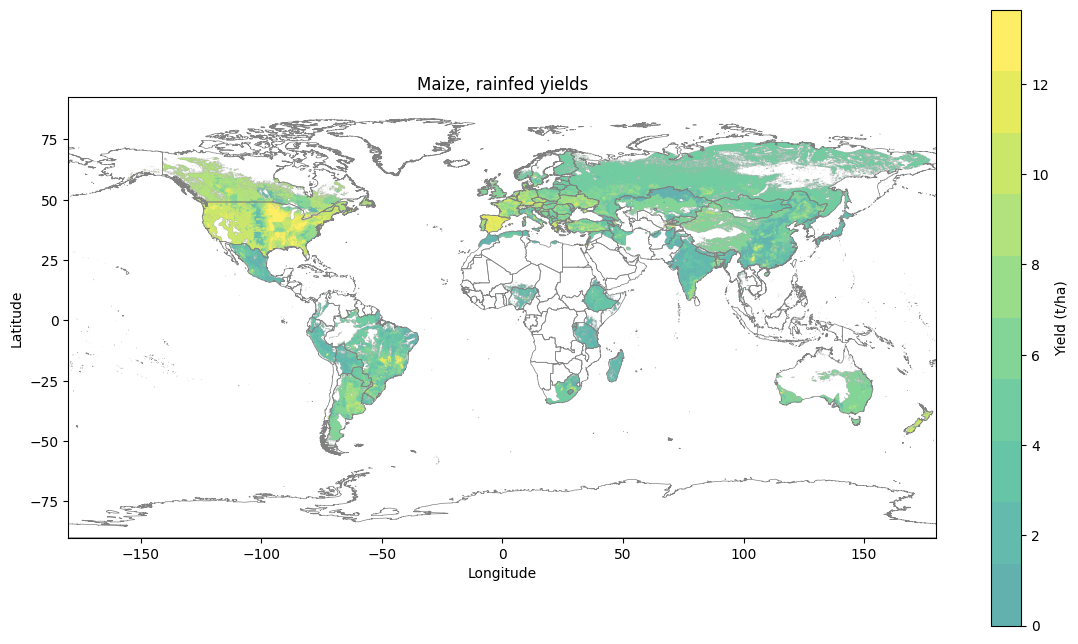

In [6]:
mplot.plot_raster_on_world_extremes_cutoff(
    tif_path=maize_rf_yields,
    title="Maize, rainfed yields",
    label_title="Yield (t/ha)",
    quantiles=10
)

Maize PET - Monthly

In [7]:
maize_pet_monthly = "data/example/Maize_pet_monthly.tif"

Raster has 993,711 different values. Min: 0.00. Max: 256.88
Using quantiles
All positives route


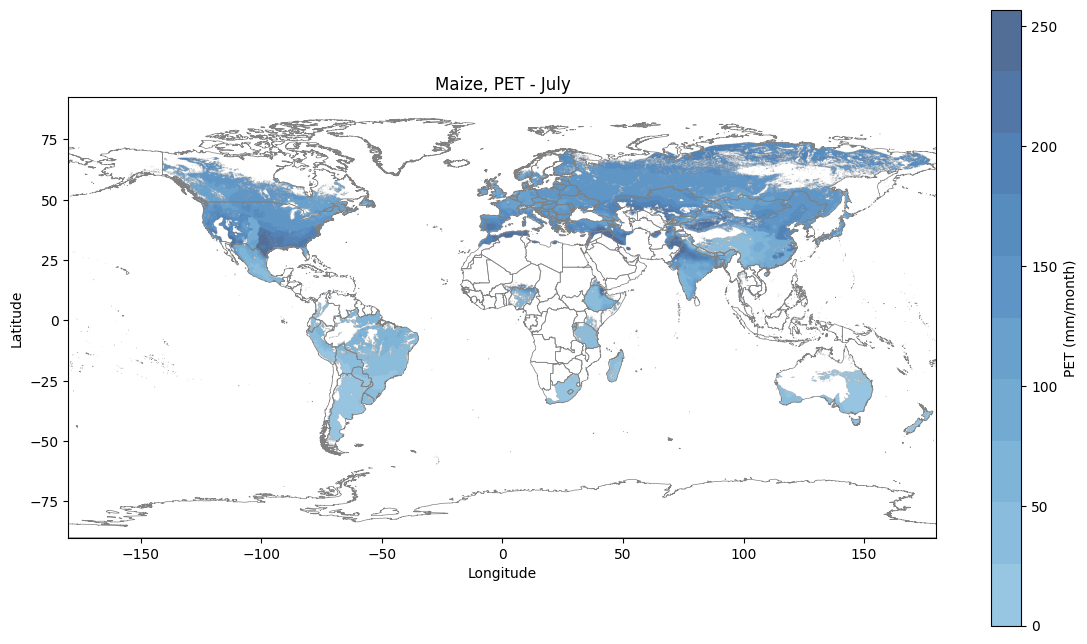

In [11]:
mplot.plot_raster_on_world_extremes_cutoff(
    tif_path=maize_pet_monthly,
    title="Maize, PET - July",
    raster_band=7,
    label_title="PET (mm/month)",
    quantiles=10,
    cmap="Blues"
)

## RothC Modelling
With all data generated, the RothC model can be run. SoilGrids SOC most data is from 2016, so in order to generate 2030 and 2050 maps aligned with SBTi's short and long-term targets, two LEAF will be generated: 34 and 54 years. Further, in this case, plant residues will be removed from the field, and traditional tillage applied.

Defining the needed additional inputs:

In [8]:
evap = "data/example/Maize_pet_monthly.tif"
pc = "data/example/Maize_pc_monthly.tif"
leaf_output_folder = "LEAFs/example"

Now running the RothC model. Depending on the amount of years and land modelled, this could take from a few minutes to 1+ hours.

Running for 2030 scenario 

In [10]:
reload_rothC()

In [ ]:
leaf_maize_rf_resoff_ct_2030 = rothC.run_RothC(
    crop_name="Maize",
    practices_string_id="rf_resoff_ct",
    n_years=34,
    save_folder="leaf_output_folder",
    data_description="RothC model results after 34 years for Maize, rainfed, residues removed from field, conventional tillage",
    lu_fp=lu_filepath,
    evap_fp=evap,
    pc_fp=pc
)

Loading environmental data...
Loading crop data...
Running RothC...


c:\Users\loyola\OneDrive - World Wildlife Fund, Inc\Documents\203. Python projects\SBTN_Test\leaf_utils\RothC_Core.py:56: RuntimeWarning: overflow encountered in exp
  rmf = 47.91 / (np.exp(106.06 / (tmp + 18.27)) + 1.0)
